# Dengue Modeling Stat Analysis Script
*Created Feb 15, 2017 by Jerelyn Co*

Script generating **pearson's r**, **p-value**, and **nrmse** results from simulation results and validator files from DOH data

Python libraries used:
    - numpy
    - pandas
    - scipy
    - os


In [21]:
# Importing libraries
import os
import shutil

import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr

%matplotlib inline
import seaborn as sns

"""
@desc   
@return  
"""
def nrmse(p, t):
    return np.sqrt( ((p-t)**2).mean() ) / (p.max() - p.min())

"""
@desc    
@return
"""
def generate_monthly(year_range, month_range):
    # Constants
    YEAR = year_range
    MONTH = month_range
    
    # Initializing dataframes for result
    monthly_res = pd.DataFrame(columns=("year", "month", "pearsonr", "pval", "nrmse"))

    # Iterating per year and per month
    idx = 0
    for year in range(YEAR[0], YEAR[1] + 1):
        for month in range(MONTH[0], MONTH[1] + 1):
            # Loading dataframes to compare for correlation and NRMSE
            sim_res_df = pd.read_csv("Decorator_{0}-{1:02d}/dengue/human/I_0.csv".format(year, month))
            validator_df = pd.read_csv("validators/Cumulative14Days_{0}-{1:02d}.csv".format(year, month))

            # Flatten-ing dataframes and excluding first two columns: iteration and time
            sim_res_flatten = sim_res_df.iloc[:,2:].values.flatten()
            validator_flatten = validator_df.iloc[:,2:].values.flatten()

            # Computing pearson r and p-value
            pr, pval = pearsonr(sim_res_flatten, validator_flatten)
            
            # Computing nrmse
            error = nrmse(sim_res_flatten, validator_flatten)
            
            # Adding new row of results to dataframe
            monthly_res.loc[idx] = [str(year), "{0:02d}".format(month), pr, pval, error]
            
            
            idx += 1
            
    return monthly_res

"""
@desc    
@return
"""
def generate_yearly(monthly_data, year_range):
    YEAR = year_range
    
    # Initializing dataframes for result
    yearly_res = pd.DataFrame(columns=("year", "pearsonr", "pval", "nrmse"))
    
    idx = 0 
    for year in range(YEAR[0], YEAR[1] + 1):
        yearly_mean = monthly_data[monthly_data["year"] == str(year)][["pearsonr", "pval", "nrmse"]].mean()
        yearly_res.loc[idx] = [str(year), yearly_mean[0], yearly_mean[1], yearly_mean[2]]
        idx += 1
    return yearly_res


"""
@desc    
@return
"""
def plot_yearly(x=None, y=None, ylim=None, data=None):
    sns.set_style("whitegrid")
    ax = sns.barplot(x=x, y=y, data=data)
    ax.set(ylim=ylim)
    
"""
@desc    
@return
"""   
def generate_files(project_name, dest_path):
    year_range=[2012, 2015]
    month_range=[1, 12]
    # Generating results
    monthly_res = generate_monthly(year_range, month_range)
    yearly_res = generate_yearly(monthly_res, year_range)
    
    # Writing results to csv
    yearly_res.to_csv(dest_path + "/yearly_results.csv")
    monthly_res.to_csv(dest_path + "/monthly_results.csv")

def graph_results(is_generate=False, version_dir=""):
    # Paths
    project_name = "DenguePhilippinesGeneric"
    main_path = "/home/fassster/stem/workspace/" + project_name
    dest_path = main_path + "/" + version_dir + "/"
    wd_path = main_path + "/saved_sims"

    # Set working directory
    os.chdir(wd_path)

    # Generate files
    if is_generate == True:
        generate_files(project_name, wd_path)

        files = os.listdir(wd_path)

        for f in files:
            if (f.startswith("Decorator") or f.endswith(".csv")):
                shutil.move(f, dest_path)
    
    # Set working directory
    os.chdir(dest_path)

    # Load yearly results
    yearly_res = pd.read_csv("yearly_results.csv")

    # Plotting of results
    plt.figure()
    plot_yearly(x="year", y="pearsonr", ylim=(0,1), data=yearly_res)
    plt.figure()
    plot_yearly(x="year", y="nrmse", ylim=(yearly_res["nrmse"].min(), yearly_res["nrmse"].max() + 1), data=yearly_res)


## Results from Sir Rjel's suggestion
Revisions as follow:
- delta transmissionRate\*S\*(effective(i)/(ratioAedesToHuman\*0.5)); **changed** to delta transmissionRate\*S\*effective(i)\*ratioAedesToHuman\*0.5;
- Infectious Mortality rate : 2.9 -> 0.0 
- RatioAedesToHuman : 0.1 -> 2.0


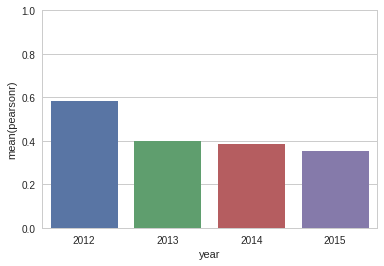

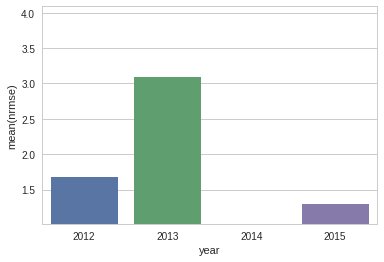

In [7]:
graph_results(is_generate=False, version_dir="v1.0")

## Results from more precised parameters


Retained transmission rate equation:
- delta transmissionRate\*S\*effective(i)\*ratioAedesToHuman\*0.5;

Parameters used:
- Transmission Rate: 0.329/day
- Recovery Rate: 0.146/day
- Infectious Mortality Rate: 0.01 / day
- Incubation Rate (host): 0.178/day
- Ratio Aedes to Human: 1.9
- Immunity Loss Rate: 0.0645/day

[Link for the parameters and their sources, see v1.1](https://docs.google.com/document/d/1nSITohhPkUt8FH-g1SiLuK3lYASVfCieePMzFy22Gq4/edit)

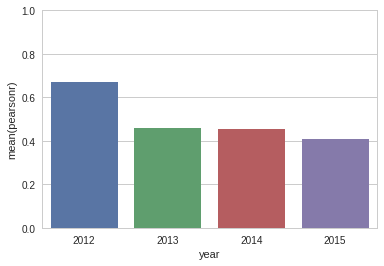

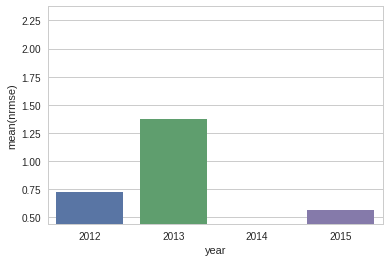

In [8]:
graph_results(is_generate=False, version_dir="v1.1")

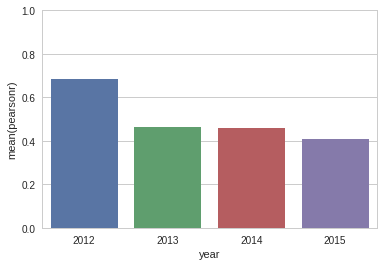

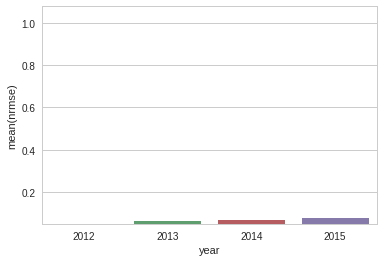

In [23]:
graph_results(is_generate=True, version_dir="v1.3")